# <center> Variational Quantum Eigensolver for Halogens Vibrational Frequencies </center> <center>  <font size="3"> By Yu (Randy) Shee @ Bleximo Corp. </font> </center>
In this demo, we use the Variational Quantum Eigensolver (VQE) to find the ground state energies of Halogens (diatomic molecules) with the help of a qubit-efficient encoding scheme. These molecules can be simulated on a 6-qubit quantum device using hardware-efficient ansatz circuits. We further use a finite difference method (three-point stencil) to find the vibrational frequencies of the molecules. Feel free to change/optimize the quantum circuits, training paramters, and optimizers.

## I. Introduction 
One of the most promising application for noisy intermediate-scale quantum (NISQ) devices is quantum simulation of electronic structure. The variational quantum eigensolver helps find ground-state energy using variational principle and possibly provides a speed-up over classical full configuration-interaction (full CI) method or the diagonalization of a Hamiltonian. With the ground-state potential energy surface (PES), some molecular properties such as the vibrational frequency can be obtained.

To start with, let's import neccesary packages for this demo. 

In [1]:
# I use qiskit==0.25.4 here
import qiskit
print(qiskit.__qiskit_version__)

# Ignore warnings for a clear view
import warnings
warnings.filterwarnings('ignore')

# Packages for constructing Hamiltonian
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator, MP2Info
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import HFMethodType
from groupedFermionicOperator import groupedFermionicOperator
from qiskit.aqua.algorithms import NumPyEigensolver

# Math and visualization tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Packages for VQE
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP, AQGD
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.aqua.algorithms import VQE
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.aqua import QuantumInstance

# Monitor runtime
import time

{'qiskit-terra': '0.17.2', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.4', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


## II. Choose a Molecule (Halogens) to Simulate 
Pick one of the Halogens (comment out MOLECULE_NAME) you would like to simulate. You will be given the equilibrium bond lengths (EQ_BOND_LENGTH) optimized in STO-3G basis set using PySCF, the experimental vibrational frequencies (EXP_VIB_FREQ) from the NIST Diatomic Spectral Database $[1]$, a Z-matrix coordinate of the molecule (ATOM_COORD) where the missing Z-coordinate of the second atom will be filled in by the bond distances in DISTANCES, atomic mass, and the index where the freezing of molecular orbital should stop (FREEZE_END). You can also choose the displacement away from equilibrium or the precision (DELTA_X) you prefer for the finite difference method. Since the equilibrium bond lengths are given here, choosing a better precision would not affect the calculation time (for precision smaller than 0.01, might need to evaluate equilibrium bond distance at the same precision).

In [2]:
# Choose from the four Halogens
# molecule_name = "F2"
molecule_name = "Cl2"
# molecule_name = "Br2"
# molecule_name = "I2"

In [3]:
def get_molecule_properties(molecule_name):
    """
    Get equilibrium bond length (Å), NIST experimental vibrational frequency (1/cm),
    Z-matrix coordinate to build moecule, atomic mass (amu), and the last orbital
    index to freeze
    """
    if molecule_name == "F2":
        eq_bond_length = 1.39
        exp_vib_freq = 916.64
        atom_coord = "F 0 0 0; F 0 0 "
        atom_mass = 18.998403
        freeze_end = 1
    elif molecule_name == "Cl2":
        eq_bond_length = 2.13
        exp_vib_freq = 559.7
        atom_coord = "Cl 0 0 0; Cl 0 0 "
        atom_mass = 35.453
        freeze_end = 9
    elif molecule_name == "Br2":
        eq_bond_length = 2.34
        exp_vib_freq = 325.321
        atom_coord = "Br 0 0 0; Br 0 0 "
        atom_mass = 79.904
        freeze_end = 27
    elif molecule_name == "I2":
        eq_bond_length = 2.75
        exp_vib_freq = 214.5
        atom_coord = "I 0 0 0; I 0 0 "
        atom_mass = 126.90447
        freeze_end = 45
    else:
        print("Choose the above four molecules")
        raise
    return eq_bond_length, exp_vib_freq, atom_coord, atom_mass, freeze_end

In [4]:
# Get properties of the given molecule
eq_bond_length, exp_vib_freq, atom_coord, atom_mass, freeze_end = get_molecule_properties(molecule_name)

# Choose displacement away from equilibrium bond length for finite difference method
delta_x = 0.01

# List the bond distances we will be monitoring
distances = [eq_bond_length - delta_x, eq_bond_length, eq_bond_length + delta_x]

## III. Build Hamiltonian for Simulation

### Second-Quantized Hamiltonian $[2]$ $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$ $\newcommand{\bra}[1]{\left\langle{#1}\right|}$
The second-quatized formalism of a molecular Hamiltonian under Born-Oppenheimer approximation (BOA) can be written as $$H=\sum_{pq}{h_{pq}a_p^\dagger a_q}+\frac{1}{2}\sum_{pqrs}{h_{pqrs}a_p^\dagger a_q^\dagger a_ra_s} $$
where $a_p^\dagger$ and $a_p$ are the creation and annihilation operators. If we define the electronic configuration of a $N$-spin-orbital electronic system in a occupation number vector form as $\ket{\mathbf f}_{\text{f}} = \ket{f_{N-1},...,f_0}_{\text{f}}$ with $f_i = \{0, 1\}$, the fermionic operators can be written as 
$$ a_p^\dagger \ket{f_{N-1}, \cdots, f_p,\cdots, f_0} = \delta_{f_p, 0} (-1)^{\sum_{i=0}^{p-1} f_i} \ket{f_{N-1}, \cdots, 1\oplus f_p,\cdots, f_0} $$
$$ a_p \ket{f_{N-1}, \cdots, f_p,\cdots, f_0} = \delta_{f_p, 1} (-1)^{\sum_{i=0}^{p-1} f_i} \ket{f_{N-1}, \cdots, 1\oplus f_p,\cdots, f_0} $$
where the coefficients could be ±1 according to the antisymmetric property of fermions.

### Qubit Hamiltonian $[2]$ 
In order to simulate electronic systems on (qubit-based) quantum devices, the electronic configurations and the fermionic operators have to be mapped onto qubits. Traditionally, the Jordan-Wigner (JW) transformation is often used where the occupations are mapped onto each of the qubits of an $N$-qubit system as
$$ \ket{f_{N-1},...,f_0} \rightarrow \ket{q_{N-1},...,q_0} \textrm{ with } f_i = q_i. $$
And the fermionic operators are straightforwardly given by
$$ a_p^\dagger = Q_p^\dagger \otimes Z_{p-1}\otimes\cdots\otimes Z_0 $$
$$ a_p = Q_p \otimes Z_{p-1}\otimes\cdots\otimes Z_0 $$
where $Q_p^\dagger=\frac12 (X_p-iY_p)$, $Q_p = \frac12 (X_p+iY_p)$, and the Z-Pauli strings address the antisymetric property of fermions. As we want to work on NISQ devices, an $O(N)$ qubit count might not be practical as the circuit depth also would not permit. Therefore, we resort to a qubit-efficient encoding method to map electronic configurations and fermionic operators onto fewer qubits.

### Qubit-Efficient Encoding $\require{mhchem}$
The qubit efficient encoding (QEE) scheme proposed in $[3]$ reduces qubit requirements by only mapping the electronic configurations with certain symmetries onto qubit basis states since not all configurations are physical and contributes to the ground state. Take an $\ce{H_2}$ molecule in the minimal basis set (4 spin-orbitals and 2 electrons) for example, the configuration $\ket{f_{\sigma_{1s, u\downarrow}}, f_{\sigma_{1s, g\downarrow}}, f_{\sigma_{1s, u\uparrow}} f_{\sigma_{1s, g\uparrow}}} = \ket{0000}_{\text{f}}$ is a valid occupation number vector, but it implies that all spin-orbitals are not occupied, which is not the case if we are considering a particle-conserving quantum many-body system. If we know that the ground state should have the symmetry such that it is particle conserving and singlet (zero spin), only 4 configurations ($\ket{0101}_{\text{f}}$, $\ket{0110}_{\text{f}}$, $\ket{1001}_{\text{f}}$, and $\ket{1010}_{\text{f}}$) have to be considered, so only 2 qubits are needed in this case. 

More foramlly, we map the set of all particle-conserved (or with other symmetries) configurations $\mathcal F_m = \{\ket{\mathbf f_i}_{\text{f}} \ | \ |\mathbf f_i| = m\}$ onto $Q$-qubit basis states $\mathcal Q_Q = \{\ket{\mathbf q_0}_{\text{q}}, \ket{\mathbf q_1}_{\text{q}}, ...\}$ where $m$ is the number of electrons. The order of the mapping from configurations to qubit basis set can be arbitrary, but we chose to order both the sets ascendingly (according to their values converted from binary to decimal) such that the Hartree-Fock configuration will be mapped to the qubit basis state with zeros on all bits. Take the $\ce{H_2}$ case for example again, the $\ket{0101}_{\text{f}}$ configuration will thus be mapped to $\ket{00}_{\text{q}}$.

Please refer to $[3]$ for the mapping from fermionic operators to qubit operators. The preliminary for this demo is to know that QEE qubit Hamiltonian is also a linear combination of tensor products of Pauli operators. For qubit count, if we are only considering particle-conserving configurations, $Q = \left\lceil \log_2{N\choose m} \right\rceil$ which is $\mathcal O(m\log_2(N))$ for $m <\!\!< N$ and $Q = \mathcal O((N-m)\log_2(N))$ for $m \approx N$. This is an exponential saving of qubits as we move to larger quantum systems. Nevertheless, the drawback of this method is that it takes slightly longer classical preprocessing time to prepare the qubit Hamiltonian comparing to JW encoding.

Here, we utilize the code from $[4]$ to construct QEE qubit Hamiltonian for the chosen Halogen at three bond distances (equilibrium bond distance, left, and right of that distance according to desired precision DELTA_X). Note that some of the molecular orbitals are frozen as they do not affect ground state energy calculation in this case. The number of spin-orbitals for the four Halogens (with some orbital being frozen) is 16 so it requires 16 qubits for JW encoding and 6 qubits for QEE to simulate on quantum devices. We also find the Hartree-Fock energies and exact energies of the Hamiltonian at the bond distances for reference.

In [5]:
def get_qubit_op_QEE(atom_coord):
    """
    Returns the qubit Hamiltonian, number of particles, number of spin orbitals, and the energy shift. 
    Code is modified from Qiskit textbook 4.1.2 "Simulating Molecules using VQE".
    See https://qiskit.org/textbook/ch-applications/vqe-molecules.html
    A qubit efficient encoding method has also been used to allocate qubits efficiently.
    See https://github.com/m24639297/qubit-efficient-mapping
    and https://arxiv.org/abs/2110.04112
    """
    # Build the molecule
    driver = PySCFDriver(atom=atom_coord, unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Freeze or remove orbitals
    freeze_list = [i for i in range(freeze_end + 1)]
    remove_list = []
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    # Construct second quantized Hamiltonian
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    shift = energy_shift + repulsion_energy
    # Use qubit efficient encoding to map fermionic operators to qubit operators
    # See https://github.com/m24639297/qubit-efficient-mapping
    g = groupedFermionicOperator(ferOp, num_particles, mode='rhf')
    qubitOp = g.to_paulis()
    return qubitOp, num_particles, num_spin_orbitals, shift

In [6]:
qubitOp_list = []
shift_list = []
# Program starting time
start = time.time()

# Program starts
for i, dist in enumerate(distances):
    qubitOp_QEE, num_particles_QEE, num_spin_orbitals_QEE, shift_QEE = get_qubit_op_QEE(atom_coord + str(dist))
    print("Diatomic Distance:", round(distances[i], 2), "Å")
    print("Qubit Hamiltonian:", qubitOp_QEE)
    print("Number of particles:", num_particles_QEE) 
    print("Number of spin orbitals:", num_spin_orbitals_QEE)
    print("Energy shift:", shift_QEE, "Ha")
    print("--------------------------------------------------")
    qubitOp_list.append(qubitOp_QEE)
    shift_list.append(shift_QEE)
# Program ends

# Program ending time
end = time.time()

# Runtime taken
print("Runtime of constructing the qubit Hamiltonian", end - start, "s")

Diatomic Distance: 2.12 Å
Qubit Hamiltonian: Representation: paulis, qubits: 6, size: 1040
Number of particles: 14
Number of spin orbitals: 16
Energy shift: -867.8854152802367 Ha
--------------------------------------------------
Diatomic Distance: 2.13 Å
Qubit Hamiltonian: Representation: paulis, qubits: 6, size: 1040
Number of particles: 14
Number of spin orbitals: 16
Energy shift: -867.9427720464375 Ha
--------------------------------------------------
Diatomic Distance: 2.14 Å
Qubit Hamiltonian: Representation: paulis, qubits: 6, size: 1040
Number of particles: 14
Number of spin orbitals: 16
Energy shift: -867.9995930332474 Ha
--------------------------------------------------
Runtime of constructing the qubit Hamiltonian 56.12528610229492 s


In [7]:
# Get Hatree-Fock energy for reference
hf_energy_list = []
for dist in distances:
    driver = PySCFDriver(atom=atom_coord + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    hf_energy_list.append(molecule.hf_energy)

In [8]:
exact_energy_list = []
# Find the exact energies of the molecules at the bond distances
for i, dist in enumerate(distances):
    result = NumPyEigensolver(qubitOp_list[i]).run()
    exact_energy = np.real(result.eigenvalues)[0] + shift_list[i]
    print("Distance:", round(dist, 2), "Å:", "STO-3G Energy:", exact_energy, "Ha")
    exact_energy_list.append(exact_energy)

Distance: 2.12 Å: STO-3G Energy: -909.1488398738547 Ha
Distance: 2.13 Å: STO-3G Energy: -909.148874770603 Ha
Distance: 2.14 Å: STO-3G Energy: -909.1488360792284 Ha


## IV. Variational Quantum Eigensolver $[5]$
Variational quantum eigensolver (VQE) is a method to solve eigenvalues using variational principle.

### Variational Principle
Let $\ket{\Psi}$ be a normalized trial wavefunction/solution to the electronic Hamitonian $H$. The variational principle gives $$ E = \bra{\Psi}H\ket{\Psi} \geq E_0 = \bra{\Psi_0}H\ket{\Psi_0}, $$ where $E_0$ is the lowest eigenvalue of $H$ and $\ket{\Psi_0}$ is the corresponding eigenvector. Therefore, we can parametrize the trial wavefunction and variationally tune the parameters to approximate the ground state energy of a given Hamiltonian. To implement this algorithm, we parametrize $\ket{\Psi}$ by a quantum circuit $U(\boldsymbol{\theta})$ to get $\ket{\Psi(\boldsymbol{\theta})} = U(\boldsymbol{\theta}) \ket{\Psi_{\text{ref}}}$ where the reference state $\ket{\Psi_{\text{ref}}}$ has significant overlap with the ground state $\ket{\Psi_0}$. People often choose the  Hartree-Fock states or multiconfigurational states as the reference state.

The quantum circuit, often called ansatz circuit, could be a chemistry-inspired circuit or a hardware-efficient circuit. For chemistry-inspired ansatz circuits like unitary coupled cluster (UCC) ansatz circuit, symmetries are used to build the circuit so the ground state could be search in a confined space, but the circuit depth is often too deep for near term devices. For hardware-efficient ansatz circuits, the quantum gates are native gates of the quantum device so they are easier to execute, but one would have to go through a heuristic search of the whole Hilbert space for ground state. 

The parameters of the circuits will then be optimized using classical algorithms such as the gradient descent method. 

### Build Ansatz Circuit and Choose Parameters  for VQE

Since we have selected significant configurations, a heuristic search of the whole Hilbert space is equivalent to a search in the symmetry-space like chemistry-inspired ansatz. Therefore, we chose to use a simple hardware-efficient ansatz circuit. We chose Hartree-Fock state to be the reference state as it corresponds to the qubit basis state with zeros for all bits. 

As we are using a very simple ansatz, it might not be enough to capture the lowest energies, but it is good enough (for this demo) to find molecular properties. So for future work, you can optimize the circuit or change the optimzer and parameters for optimization.

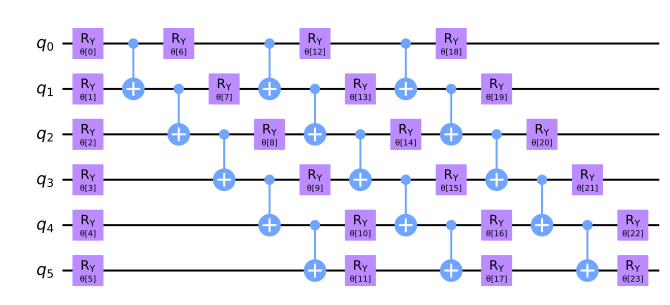

In [9]:
# Choose ansatz and can add additional rotation layers
# Please refer to arXiv:2110.04112 for why we chose hardware-efficient ansatz here
ansatz = RealAmplitudes(6, entanglement='linear', reps=3)
#ansatz = EfficientSU2(6, entanglement='linear', reps=3)

# # Add rx to rotation block
# theta = Parameter('θ')
# rx_rotation = QuantumCircuit(1)
# rx_rotation.rx(theta, 0)
# ansatz.rotation_blocks.append(rx_rotation)

ansatz.draw('mpl');

In [10]:
iterations = 5000
num_shots = 1024
# optimizer = COBYLA(maxiter=iterations)
# optimizer = SPSA(maxiter=iterations)
optimizer = SLSQP(maxiter=iterations)
# foptimizer = AQGD(maxiter=iterations)
backend = Aer.get_backend('statevector_simulator')

### VQE Experiments (Noiseless Simulation)
We then run the VQE experiments on a noiseless simulator. The VQE, Hartree-Fock, and the exact energies of the qubit Hamiltonian at given distances are printed where the errors have units of kcal/mol which is the unit that represents chemical accuracy. You can also visualize the convergence of the optimizatino as we store the values in the process.

In [11]:
# Ansatz circuit initial parameters for rotations
initial_point = [0.]*ansatz.num_parameters

# This is for re-optimization using previous parameters from optimization
# initial_point = result['optimal_point']

counts_list = []
values_list = []
vqe_result_list = []
vqe_energy_list = []
for i, qubitOp_QEE in enumerate(qubitOp_list):
    # Store optimization results
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    # Run VQE
    seed = 0 # For consistent results on simulator
    qi = QuantumInstance(backend=backend, shots=num_shots, seed_simulator=seed)
    vqe = VQE(var_form=ansatz, optimizer=optimizer, callback=store_intermediate_result, 
              quantum_instance=qi, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator=qubitOp_QEE)
    # Store all results
    counts_list.append(counts)
    values_list.append(values)
    vqe_result_list.append(result)
    vqe_energy = result.eigenvalue.real + shift_list[i]
    vqe_energy_list.append(vqe_energy)
    print("Diatomic Distance:", round(distances[i], 2), "Å")
    print("Exact energy:", exact_energy_list[i], "Ha")
    print("VQE energy:", vqe_energy, "Ha")
    print("VQE Error:", abs(exact_energy_list[i] - vqe_energy) * 627.5, "kcal/mol")
    print("HF energy:", hf_energy_list[i], "Ha")
    print("HF Error:", abs(exact_energy_list[i] - hf_energy_list[i]) * 627.5, "kcal/mol")
    print("Evaluation counts:", result['cost_function_evals'])
    print("--------------------------------------------------")

Diatomic Distance: 2.12 Å
Exact energy: -909.1488398738547 Ha
VQE energy: -909.1447877603076 Ha
VQE Error: 2.542701250816606 kcal/mol
HF energy: -909.1134533715592 Ha
HF Error: 22.20503019044088 kcal/mol
Evaluation counts: 1331
--------------------------------------------------
Diatomic Distance: 2.13 Å
Exact energy: -909.148874770603 Ha
VQE energy: -909.144843598397 Ha
VQE Error: 2.5295605592995685 kcal/mol
HF energy: -909.1128316174343 Ha
HF Error: 22.61707861338948 kcal/mol
Evaluation counts: 1330
--------------------------------------------------
Diatomic Distance: 2.14 Å
Exact energy: -909.1488360792284 Ha
VQE energy: -909.1448569697958 Ha
VQE Error: 2.496891168978266 kcal/mol
HF energy: -909.1121252283937 Ha
HF Error: 23.036058898815384 kcal/mol
Evaluation counts: 1303
--------------------------------------------------


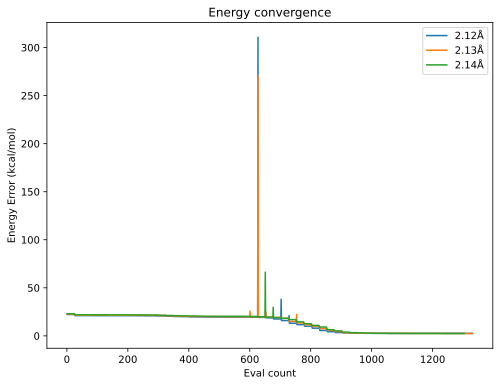

In [12]:
plt.figure(figsize=(8, 6))
for i, dist in enumerate(distances):
    energy_errors = ((values_list[i] + shift_list[i]) - exact_energy_list[i]) * 627.5
    plt.plot(counts_list[i], energy_errors, label=str(round(dist, 2))+"Å")
plt.xlabel('Eval count')
plt.ylabel('Energy Error (kcal/mol)')
plt.title('Energy convergence')
plt.legend()

## V. Finite Difference Method for Vibrational Frequency 
In this section, we will treat nuclei as classical particles (BOA treats electrons quantum mechanically) to obtain vibrational frequency of the selected diatomic molecule. With Newton's equation of motion 
$$ \frac{d^2\Delta{x}}{dt^2} = \frac{F}{m} \text{  and  }
F = -\frac{d{E}}{d{x}} = -\frac{d{E}}{d{\Delta{x}}}, $$ 
where $E$ is the total energy, $x$ is the bond distance, and $\Delta{x}$ is the displacement away from equilibrium bond distance $x_0$. For small displacements, the Taylor expansion of the total energy is 
$$ E(x) = E(x_0) + \Big(\frac{d{E}}{d{x}}\Big)^{(0)}\Delta{x} + \frac12\Big(\frac{d^2{E}}{d{x^2}}\Big)^{(0)}{\Delta{x}}^2 + \mathcal{O}({\Delta{x}}^3).$$

$\Big(\frac{d{E}}{d{x}}\Big)^{(0)} = 0$ at equilibrium and $H_1 = \Big(\frac{d^2{E}}{d{x^2}}\Big)^{(0)}$ is the 1-D Hessian matrix, so we have $ F = -H_1\Delta{x} $. We can therefore solve the Newton's equation as 
$$ \Delta{x(t)} = cos\Big(\sqrt{\frac{H_1}{m}}t\Big), $$
where $\sqrt{\frac{H_1}{m}}$ is our vibrational frequency under harmonic approximation and the mass $m$ we will be using is the reduced mass of the diatomic molecules.

We use three data points of energies and the finite difference method to approximate the second derivative (Hessian) by 
$$ H_1 = \Big(\frac{d^2{E}}{d{x^2}}\Big)^{(0)} \approx \frac{E(x_0 + \Delta{x}) - 2E(x_0) + E(x_0 - \Delta{x})}{\Delta{x}^2}.$$

Here, we show vibrtional frequecies of Halogens using VQE calculated energies and exact energies under STO-3G basis set. We also give the experimental vibrtiaonl frequencies for reference. It can be seen that the errors are within sub-kcal/mol and just needs slight optimization to get better accuracy. Such further optimization is left for the readers.

In [13]:
def get_vib_freq(left, equilibrium, right, delta_x, atom1_mass, atom2_mass):
    """
    Return vibrational frequency using Three-Point Stencil Formula.
    LEFT, EQUILIBRIUM, RIGHT are the three energies we obtained.
    """
    force_constant = (left - 2*equilibrium + right) / (delta_x * delta_x)
    # reduce mass (in amu)
    mu = (atom1_mass * atom2_mass)/(atom1_mass + atom2_mass)
    # Unit conversion: sqrt(hartree) to 1/cm
    hartree_to_wavenumber = np.sqrt(5.4858 * 1e-4) * 0.5291/(2 * np.pi * 137.036 * 5.291 * 1e-9)
    vib_freq = np.sqrt(force_constant / mu) * hartree_to_wavenumber
    return vib_freq

In [14]:
vqe_vib_freq = get_vib_freq(vqe_energy_list[0], vqe_energy_list[1], 
                            vqe_energy_list[2], delta_x, atom_mass, atom_mass)
STO3G_vib_freq = get_vib_freq(exact_energy_list[0], exact_energy_list[1], 
                              exact_energy_list[2], delta_x, atom_mass, atom_mass)
print("Experimental vibrational frequency:", exp_vib_freq, "1/cm")
print("STO-3G vibrational frequency:", STO3G_vib_freq, "1/cm")
print("VQE Vibrational frequency:", vqe_vib_freq, "1/cm")
print("VQE Error from experimental =", abs(vqe_vib_freq - exp_vib_freq), "1/cm = ", 
      abs(vqe_vib_freq - exp_vib_freq) * 0.0029, "kcal/mol")
print("VQE Error from STO-3G =",  abs(vqe_vib_freq - STO3G_vib_freq), "1/cm = ", 
      abs(vqe_vib_freq - STO3G_vib_freq) * 0.0029, "kcal/mol")
print("STO-3G Error from experimental =", abs(exp_vib_freq - STO3G_vib_freq), "1/cm = ", 
      abs(exp_vib_freq - STO3G_vib_freq) * 0.0029, "kcal/mol")

Experimental vibrational frequency: 559.7 1/cm
STO-3G vibrational frequency: 554.2399263007567 1/cm
VQE Vibrational frequency: 421.034956192198 1/cm
VQE Error from experimental = 138.66504380780202 1/cm =  0.4021286270426258 kcal/mol
VQE Error from STO-3G = 133.20497010855865 1/cm =  0.38629441331482006 kcal/mol
STO-3G Error from experimental = 5.460073699243367 1/cm =  0.015834213727805763 kcal/mol


## VI. Conclusion
In this demo, we built the qubit Hamiltonian using a qubit-efficient method which makes large molecules possible to siimulate on quantum devices. We then ran the VQE experiments on a noisless simulator and obtained vibrational frequencies from the energies. With qubit-efficient encoding, we reduce both qubit counts and circuit depth drastically as we only need a simple hardware-efficient ansatz for the simulation, while UCC circuits scale at least quadratically with respect to the number of spin-orbitals $[6]$.

For future work, the code can be modified to capture other molecules and molecular properties. Also, ansatz circuit and training parameters could be optimized. Models more than just harmonic approximation that addresses anharmonicity could also be incorporated for better prediction of properties. Last but not least, the 6-qubit circuit in this demo can provide a blueprint to build applciation-driven quantum chips for VQE algorithms.

## VII. References
1. Diatomic spectral database. https://www.nist.gov/pml/diatomic-spectral-database (accessed Jan 18,  2022). 
2. McArdle et al. "Quantum Computational Chemistry." Rev. Mod. Phys. 92, 015003 (2020).
3. Shee et al. "A Qubit-Efficient Encoding Scheme for Quantum Simulations of Electronic Structure." arXiv:2110.04112 (2021).
4. Qubit-efficient encoding code repository. https://github.com/m24639297/qubit-efficient-mapping (accessed Jan 18,  2022).
5. Simulating molecules using VQE. https://qiskit.org/textbook/ch-applications/vqe-molecules.html (accessed Jan 18,  2022). 
6. Barkoutsos et al. "Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions." Phys. Rev. A 98, 022322 (2018).